In [5]:
# Imports

import pandas as pd
import numpy as np
import os
import csv
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.transformations.panel.rocket import Rocket, MiniRocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

In [2]:
# Opening up file containing GWAS data and reading in

file = open("Second_GWAS/Second_GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

110

In [3]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]

df = pd.DataFrame(columns=columns)
data = []

for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [4]:
# Checking to see split between cases and controls

df["PHENOTYPE"].value_counts()

1    55
0    54
Name: PHENOTYPE, dtype: int64

In [5]:
# Printing shape of df

df.shape

(109, 41313)

In [6]:
# Printing shape of df

df.columns

Index(['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'rs7433861',
       'rs1166974', 'rs1166975', 'rs10446372',
       ...
       'rs4030335', 'rs7374010', 'rs9877345', 'rs7373662', 'rs12630742',
       'rs11916265', 'rs7374354', 'rs9325418', 'rs9325420', 'rs10154902'],
      dtype='object', length=41313)

In [7]:
# Re-encoding the phenotype as case and control

df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [8]:
# Dropping columns and seperating phenotype column

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [9]:
# Replacing missing values in df with most common allele for that given SNP

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [10]:
# Converting columns to be numberical

dfTest = idf.apply(pd.to_numeric)

'case'

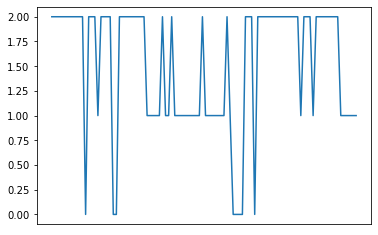

In [11]:
# Visualising first 100 SNPs of first case

dfTranspose = dfTest.T
plt.xticks([])
plt.plot(dfTranspose[0][0:100], color="tab:blue")
phenotype[0]

In [12]:
# Classifying entrire set of GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on entire dataset: {sum(results) / len(results)}")
print(confusion_matrix(yTest, yPredicted))
print(classification_report(yTest, yPredicted))

Average accuracy for RandomForest on entire dataset: 0.4818181818181818
[[ 9 10]
 [ 5  9]]
              precision    recall  f1-score   support

        case       0.64      0.47      0.55        19
     control       0.47      0.64      0.55        14

    accuracy                           0.55        33
   macro avg       0.56      0.56      0.55        33
weighted avg       0.57      0.55      0.55        33



In [13]:
# Converting df to array structure

dfTestSeries = from_2d_array_to_nested(dfTest)

In [14]:
# Classifying GWAS data using MiniRocket

results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7)
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on entire dataset: {sum(results) / len(results)}")
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Average accuracy for MiniRocket on entire dataset: 0.4787878787878789
[[ 6  9]
 [ 8 10]]
              precision    recall  f1-score   support

        case       0.43      0.40      0.41        15
     control       0.53      0.56      0.54        18

    accuracy                           0.48        33
   macro avg       0.48      0.48      0.48        33
weighted avg       0.48      0.48      0.48        33



In [16]:
# Method to generate sliding window accuracy along genome

def GenerateSlidingWindowsTest(runs, windowSize, useThreshold, classifierType, threshold=0):

    results = {}
    numberOfWindows = len(dfTest.columns) - windowSize
    
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7, random_state=1)
    
    for k in range(1,runs+1):

        print(f"Run {k}")

        validationScores = []
        testScores = []
        
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, train_size=0.7)

        for n in range(0,numberOfWindows):

            if(n%(numberOfWindows//10) == 0 and n != 0):
                print(f"Progress: {round((n/numberOfWindows) * 100)}%")
                
            windowStart = n
            windowEnd = windowStart + windowSize
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if (classifierType == "miniRocket"):
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)

                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)

                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                classifier.fit(xTrainTransform, yTrainSplit)

                yValidateTransform = minirocket.transform(xValidateWindowSeries)

                score = classifier.score(yValidateTransform,yValidate)
                
            elif(classifierType == "MrSEQL"):
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)
                ms = MrSEQLClassifier(seql_mode="clf")
                ms.fit(xTrainWindowSeries, yTrainSplit)
                yValidatePredict = ms.predict(xValidateWindowSeries)
                
                score = classifier.score(yValidatePredict,yValidate)
            
            
            elif (classifierType == "RandomForest"):
                rfc = RandomForestClassifier()
                rfc.fit(xTrainWindow, yTrainSplit)
                yPredicted = rfc.predict(xValidateWindow)
                score = accuracy_score(yPredicted, yValidate)
            
            validationScores.append(score)
            
        if useThreshold:
            windowsAboveThreshold = [n for n in validationScores if validationScores[n] > threshold]

            print(windowsAboveThresholdAfterTest)

            for window in validationScores:
                if window in results:
                    results[window] += 1#
                else:
                    results[window] = 1
        else:
            for n in range(0,numberOfWindows):
                if n in results:
                    results[n] += validationScores[n]
                else:
                    results[n] = validationScores[n]
                    
    for n in range(0,numberOfWindows):
        results[n] = results[n] / runs
        
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key
        newKeyEnd = newKeyStart + windowSize
        updatedKeyResults[f"{newKeyStart}:{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [18]:
# Method to generate moving window accuracy along genome using MiniRocket

def GenerateWindowsTest(runs, windowSize, useThreshold, classifierType, threshold=0):

    results = {}
    numberOfWindows = len(dfTest.columns) // windowSize
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7, random_state=1)
    for k in range(1,runs+1):

        print(f"Run {k}")

        validationScores = []
        testScores = []
        
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, train_size=0.7)

        for n in range(0,numberOfWindows):

            if(n%(numberOfWindows//10) == 0 and n != 0):
                print(f"Progress: {round((n/numberOfWindows) * 100)}%")
                
            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if (classifierType == "miniRocket"):
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)

                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)

                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                classifier.fit(xTrainTransform, yTrainSplit)

                xTestTransform = minirocket.transform(xValidateWindowSeries)

                score = classifier.score(xTestTransform,yValidate)
            
            elif(classifierType == "MrSEQL"):
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)
                
                ms = MrSEQLClassifier(seql_mode="clf")
                ms.fit(xTrainWindowSeries, yTrainSplit)
                yValidatePredict = ms.predict(xValidateWindowSeries)
                
                score = classifier.score(yValidatePredict,yValidate)
                
            elif (classifierType == "RandomForest"):
                rfc = RandomForestClassifier()
                rfc.fit(xTrainWindow, yTrainSplit)
                yPredicted = rfc.predict(xValidateWindow)
                score = accuracy_score(yPredicted, yValidate)
            
            validationScores.append(score)
            
        if useThreshold:
            windowsAboveThreshold = [n for n in validationScores if validationScores[n] > threshold]

            print(windowsAboveThresholdAfterTest)

            for window in validationScores:
                if window in results:
                    results[window] += 1#
                else:
                    results[window] = 1
        else:
            for n in range(0,numberOfWindows):
                if n in results:
                    results[n] += validationScores[n]
                else:
                    results[n] = validationScores[n]
                    
    for n in range(0,numberOfWindows):
        results[n] = results[n] / runs
        
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key*windowSize
        newKeyEnd = newKeyStart + windowSize
        updatedKeyResults[f"{newKeyStart}:{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [19]:
# Generating accuracy windows with MiniRocket
MiniRocketWindows25 = GenerateWindowsTest(10, 25 ,False, "miniRocket")

Run 1
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 2
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 3
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 4
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 5
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 6
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 7
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%


In [20]:
# Generating accuracy windows with RandomForest
RandomForestWindows25 = GenerateWindowsTest(10, 25 ,False, "RandomForest")

Run 1
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 2
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 3
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 4
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 5
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 6
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Run 7
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%


In [37]:
RandomForestWindows25[:10]

[('12800:12825', 0.717391304347826),
 ('2975:3000', 0.6913043478260869),
 ('33550:33575', 0.6826086956521736),
 ('21775:21800', 0.6782608695652173),
 ('1675:1700', 0.6739130434782609),
 ('1700:1725', 0.6652173913043478),
 ('14375:14400', 0.6652173913043478),
 ('1650:1675', 0.6608695652173913),
 ('13225:13250', 0.6608695652173913),
 ('23850:23875', 0.6565217391304348)]

In [9]:
# Method to plot accuracies of windows accross genome

def plotWindowAccuracy(windowToPlot):
    
    sortedWindows = []
    for n in range(len(windowToPlot)):
        window = windowToPlot[n]
        key, value = window[0], window[1]
        key = int(key.split(":")[1])
        sortedWindows.append((key,value))
        
    sortedFirst = sorted(sortedWindows, key=lambda tup: tup[0])
    keys, values = [],[]
    for n in range(len(sortedFirst)):
        keys.append(sortedFirst[n][0])
        values.append(sortedFirst[n][1])
        
    figure(figsize=(20, 6), dpi=80)
    plt.plot(keys, values, "-")

In [ ]:
# Method to save results to file

def recoredResults(windows, location, nameOfFile):
    
    if not os.path.exists(location):
        os.makedirs(location)
        
    with open(os.path.join(location, nameOfFile+".csv"), "w+") as file:
        csv_out=csv.writer(file)
        csv_out.writerow(['window','accuracy'])
        for row in windows:
            csv_out.writerow(row)

In [1]:
# Method to read results from file

def readResults(nameOfFile):
    
    if not os.path.exists(nameOfFile):
        print("Cannot find file")
        
    else:
        entries = []
        with open(nameOfFile,newline='') as file:
            csvOut=csv.reader(file,delimiter=',')
            for row in csvOut:
                if not row == ['window', 'accuracy'] and row:
                    index = row[0]
                    value = float(row[1])
                    entry = (index, value)
                    entries.append(entry)
        return entries

In [7]:
entries = readResults("Results/MiniRocket/MiniRocket25Windows.csv")

In [28]:
#recoredResults(RandomForstWindows100, "Results/RandomForst", "RandomForest100Window")
#recoredResults(RandomForstWindows50, "Results/RandomForst", "RandomForest50Window")

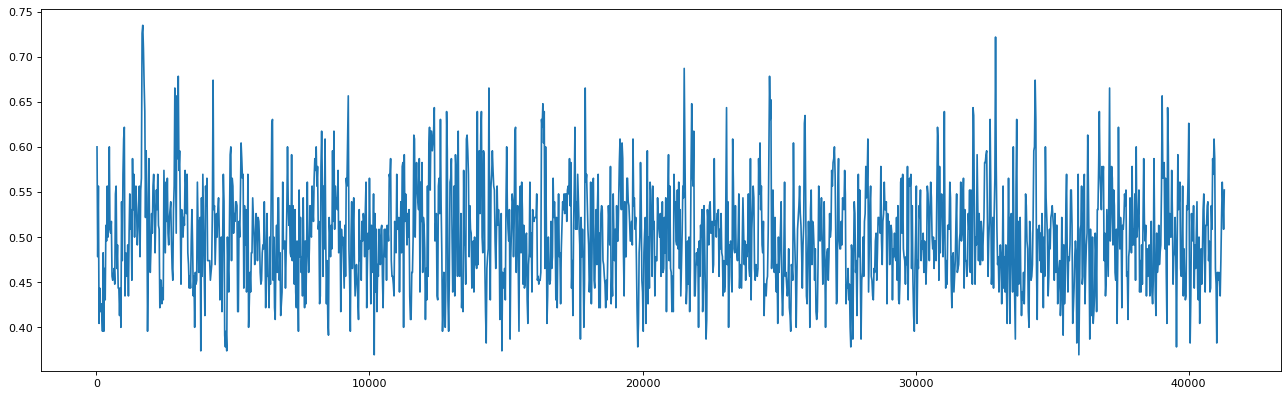

In [10]:
plotWindowAccuracy(entries)

In [39]:
# Classifying on selected window of GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest.iloc[:, np.r_[2975:3000, 12800:12825, 33550:33575]], phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on selected SNP window: {sum(results) / len(results)}")

Average accuracy for RandomForest on selected SNP window: 0.6757575757575759


<BarContainer object of 10 artists>

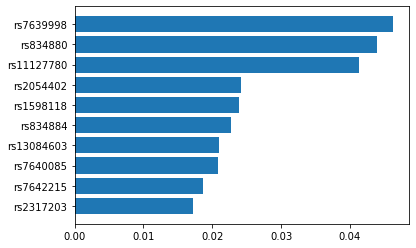

In [40]:
# Plotting feature importance of selected window from RandomForest
    
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(dfTest.iloc[:, np.r_[1650:1725]].columns[sorted_idx[-10:]], rfc.feature_importances_[sorted_idx[-10:]])

In [45]:
# Classifying on selected window of GWAS data using MiniRocket

results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest.iloc[:, np.r_[1650:1725]], phenotype, train_size=0.7)
    
    xTrain = from_2d_array_to_nested(xTrain)
    xTest = from_2d_array_to_nested(xTest)
    
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on selected SNP window: {sum(results) / len(results)}")

Average accuracy for MiniRocket on selected SNP window: 0.7333333333333335
